# Comparison of unsupervised clustering algorithms

In [1]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MeanShift, estimate_bandwidth

import hdbscan

## Data

The objective of this porject is to evaluate the utility and accuracy of several clustering algorithms.
Hence, using the `make_blobs` function from sklearn, we construct a synthetic dataset that includes uneven cluster sizes, varying density, and outliers.

The data is structured into two features stored in `X`. The variable `y` stores the true classifications, but is only used for evaluating the results of the unsupervised learning algorithms.

In [2]:
# generate data
rseed = 333

X, y, centers = make_blobs(n_samples=[400,100,50,100],
                            n_features=2, 
                            centers=[[2,2], [6,6], [6,0], [2,7]],
                            cluster_std=[1.4,1.0,0.7,1.0], 
                            random_state=rseed, return_centers=True)
X = pd.DataFrame(X)
y = pd.Series(y)

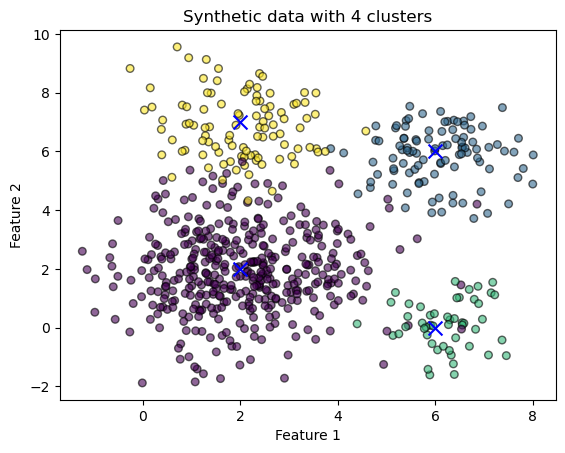

In [3]:
# Plot the blobs
plt.scatter(X[0], X[1], s=30, alpha=0.6, edgecolor='k', c = y)
plt.scatter(centers[:,0], centers[:,1], c = 'b', marker = 'x', s = 100)
plt.title('Synthetic data with 4 clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2');

Clustering algorithms typically require performing feature scaling of the data, so that distance measurements do not overestimate the importance of a certain feature over the others. However, since we are using synthetic data that are numeric and ranged between -1 to 10, we do not need to scale the features as they are already in the same range.

## K-means

In [5]:
km = KMeans(n_clusters=4, random_state=rseed)
km.fit(X);

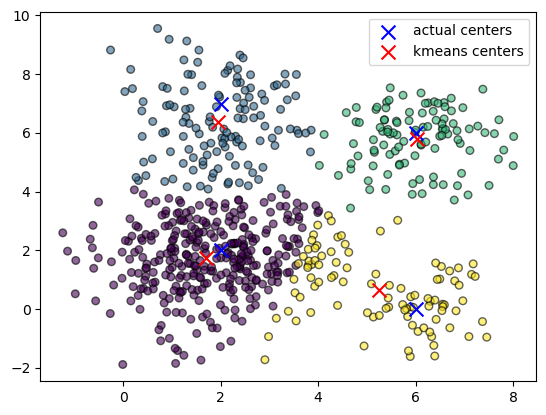

In [6]:
plt.scatter(X[0], X[1], s=30, alpha=0.6, edgecolor='k', c = km.labels_)
plt.scatter(centers[:,0], centers[:,1], c = 'b', marker = 'x', s = 100, label='actual centers')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], 
            c = 'r', marker = 'x', s = 100, label='kmeans centers')
plt.legend();

If the number of clusters in unknown, we plot the inertia and use the elbow method to deduce that the number of clusters is likely four.

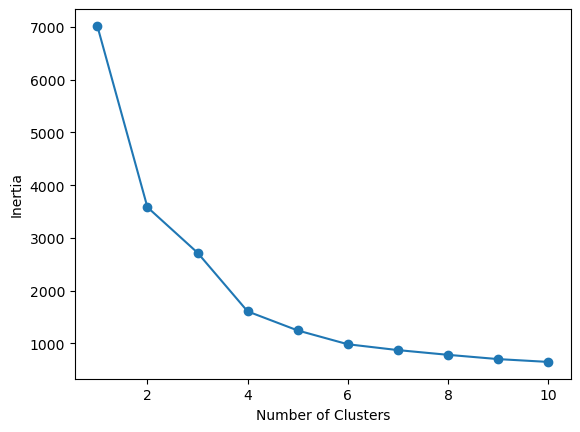

In [7]:
# plot inertia - use elbow method to find number of clusters
inertia = []
list_num_clusters = list(range(1,11))
for num_clusters in list_num_clusters:
    km = KMeans(n_clusters=num_clusters, random_state=rseed)
    km.fit(X)
    inertia.append(km.inertia_)
    
plt.plot(list_num_clusters,inertia)
plt.scatter(list_num_clusters,inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia');

The k-means algorithm correctly identified most points in the three large clusters, but due to assuming similar cluster sizes, it misclassified many points as belonging to the smallest cluster.

## Agglomerative hierarchical clustering

In [8]:
ag = AgglomerativeClustering(n_clusters=4, linkage='ward', compute_full_tree=True)
ag.fit(X);

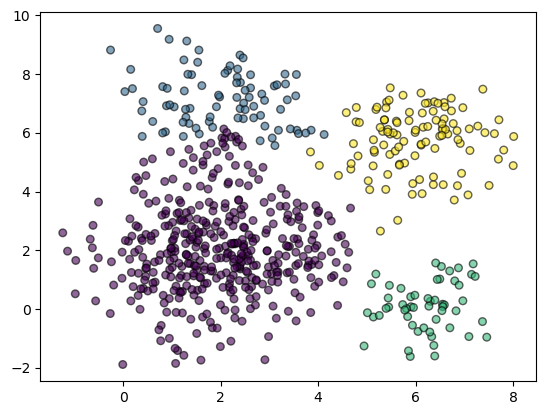

In [9]:
plt.scatter(X[0], X[1], s=30, alpha=0.6, edgecolor='k', c = ag.labels_);

The agglomerative clustering algorithm works for uneven cluster sizes, and has correctly split the data into four clusters of similar sizes to the original data. However, since it does not identify outliers, it misclassified some points in the overlap between the two largest clusters.

## Mean Shift

In [11]:
bandwidth = estimate_bandwidth(X, quantile=.3, n_samples=10)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X);

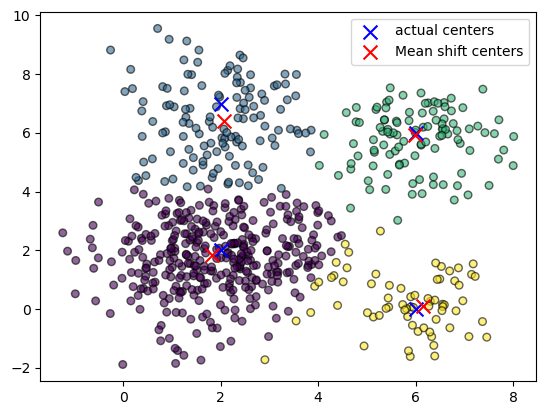

In [12]:
plt.scatter(X[0], X[1], s=30, alpha=0.6, edgecolor='k', c = ms.labels_)
plt.scatter(centers[:,0], centers[:,1], c = 'b', marker = 'x', s = 100, label='actual centers')
plt.scatter(ms.cluster_centers_[:,0], ms.cluster_centers_[:,1], 
            c = 'r', marker = 'x', s = 100, label='Mean shift centers')
plt.legend();

The mean shift algorithm performed better than k-means, with cluster centers very close to the actual centers of the data, but misclassified some points on the edges between clusters.

## HDBSCAN

In [13]:
model = hdbscan.HDBSCAN(min_cluster_size=30, min_samples = 1)
y_pred = model.fit_predict(X)

# number of clusters
print('no. clusters:', max(model.labels_) + 1)
# number of outliers
print('no. outliers:', model.labels_.tolist().count(-1))

no. clusters: 4
no. outliers: 54


/home/mkhalil/anaconda3/envs/tflow/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/mkhalil/anaconda3/envs/tflow/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


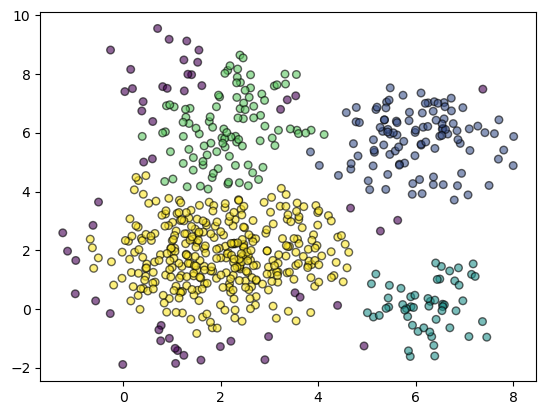

In [14]:
plt.scatter(X[0], X[1], s=30, alpha=0.6, edgecolor='k', c = model.labels_);

The HDBSCAN algorithm improves over DBSCAN by creating a hierarchical representation of clusters and then pruning this hierarchy to find the most stable clusters at different density scales. Therefore, it correctly handled the varying cluster sizes and densities, but it tended to overestimate the number of outliers.

## Conclusions

We used synthetic data with flat geometry consisting of four clusters with uneven number of points and varying densities, then tested four clustering algoriths: k-means, agglomerative hierarchical clustering, mean-shift, and HDBSCAN.

- k-means correctly identified most points in the three large clusters, but misclassified many points as belonging to the smallest cluster.
- agglomerative clustering correctly split the data into four clusters of similar sizes to the original data, but misclassified some points in the overlap between some clusters.
- mean shift performed better than k-means with cluster centers close to the true centers, but misclassified some points on the edges between clusters.
- HDBSCAN correctly handled the varying cluster sizes and densities, but tended to overestimate the number of outliers.

Hence, for data with flat geometry and uneven cluster sizes, we recommend using the agglomerative hierarchical clustering algorithm if the number of clusters is known, and recommend using the mean-shift algorithm if the number of clusters in unknown.

Possible next steps:

- Further tune the parameters of some of the algorithms to obtain better classifications.
- Use data with non-flat geometry, which is difficult for clustering algorithms.
- Test other models, such as Gaussian mixture models.